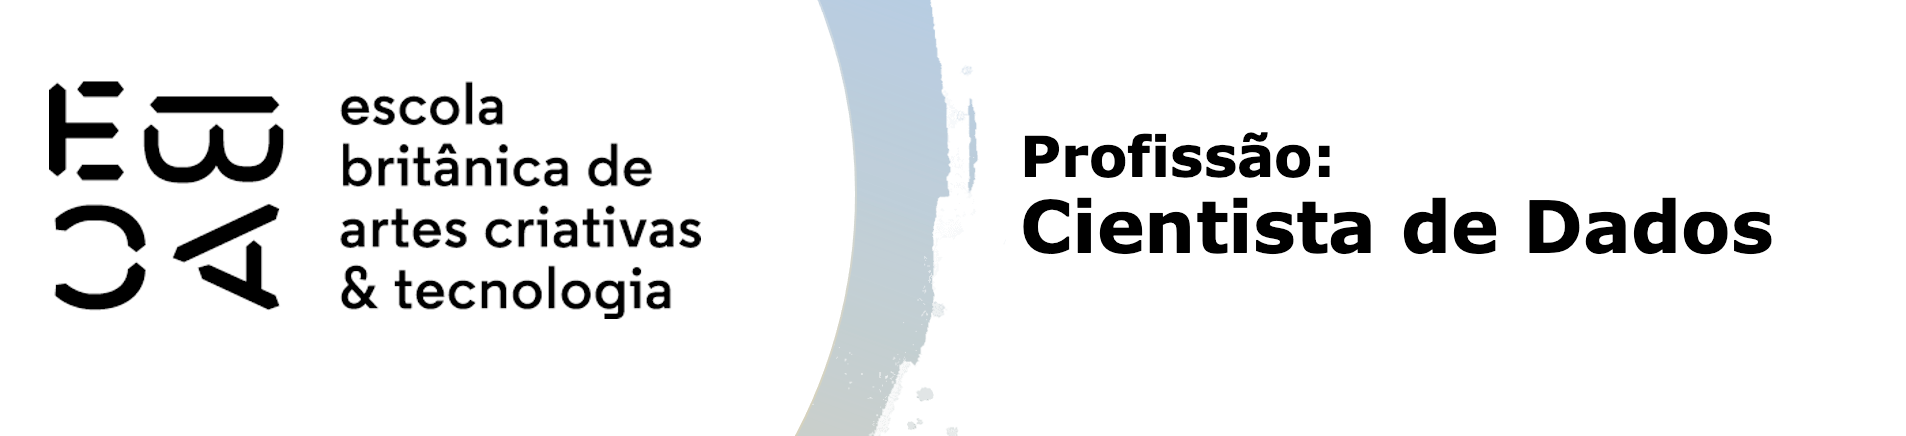

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('previsao_de_renda_II.csv')
df.head()

num_cols = df.select_dtypes(include='number').columns.drop(['index'], errors='ignore')
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

n_holdout = 90
df_holdout = df.tail(n_holdout)
df_train = df.head(len(df) - n_holdout)

print("Treino:", df_train.shape)
print("Holdout:", df_holdout.shape)

df_train['log_renda'] = np.log(df_train['renda'])
df_holdout['log_renda'] = np.log(df_holdout['renda'])

X_train = df_train.select_dtypes(include='number').drop(columns=['renda', 'index', 'log_renda'], errors='ignore')
y_train = df_train['log_renda']

X_train = sm.add_constant(X_train)

modelo = sm.OLS(y_train, X_train).fit()

print(modelo.summary())
print("R² ajustado treino:", modelo.rsquared_adj)

X_holdout = df_holdout.select_dtypes(include='number').drop(columns=['renda', 'index', 'log_renda'], errors='ignore')
X_holdout = sm.add_constant(X_holdout)
y_holdout = df_holdout['log_renda']

y_pred = modelo.predict(X_holdout)

ss_res = ((y_holdout - y_pred) ** 2).sum()
ss_tot = ((y_holdout - y_holdout.mean()) ** 2).sum()
r2_holdout = 1 - ss_res / ss_tot

print("R² holdout:", r2_holdout)

Treino: (749910, 14)
Holdout: (90, 14)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_23344\1250847116.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log_renda'] = np.log(df_train['renda'])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_23344\1250847116.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_holdout['log_renda'] = np.log(df_holdout['renda'])


                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                 1.138e+05
Date:                Sun, 17 Aug 2025   Prob (F-statistic):               0.00
Time:                        19:39:06   Log-Likelihood:            -1.0738e+06
No. Observations:              749910   AIC:                         2.148e+06
Df Residuals:                  749905   BIC:                         2.148e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.19

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

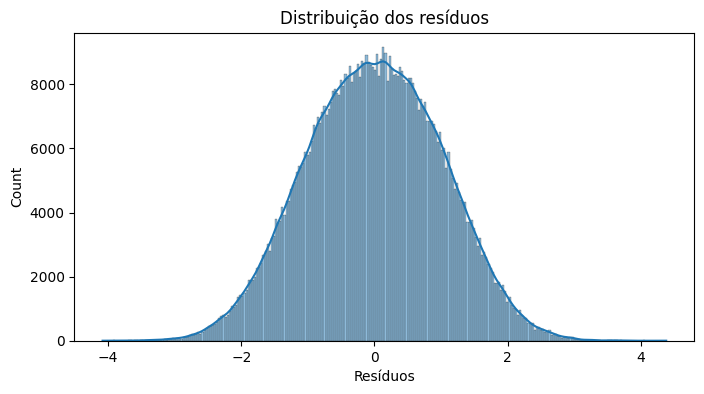

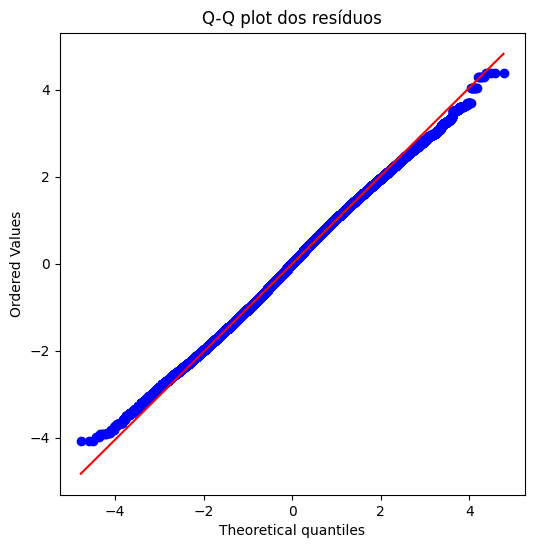

In [2]:
residuos = y_train - modelo.predict(X_train)
y_pred_train = modelo.predict(X_train)

import scipy.stats as stats

plt.figure(figsize=(8,4))
sns.histplot(residuos, kde=True)
plt.title("Distribuição dos resíduos")
plt.xlabel("Resíduos")
plt.show()

plt.figure(figsize=(6,6))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Q-Q plot dos resíduos")
plt.show()

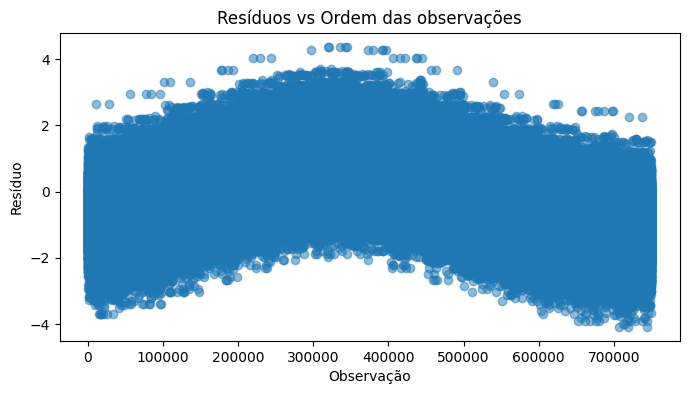

In [3]:
plt.figure(figsize=(8,4))
plt.plot(residuos.values, marker='o', linestyle='', alpha=0.5)
plt.title("Resíduos vs Ordem das observações")
plt.xlabel("Observação")
plt.ylabel("Resíduo")
plt.show()

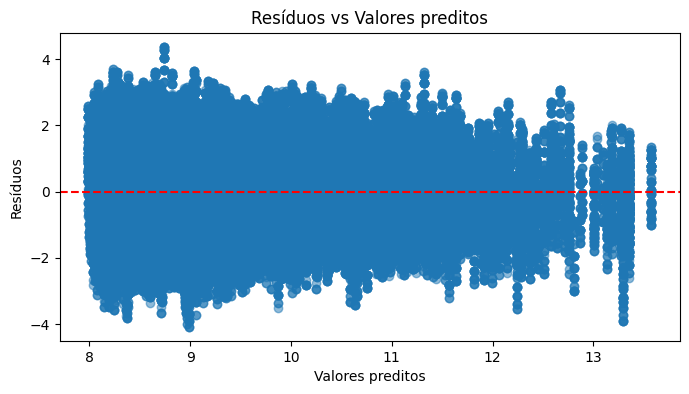

In [4]:
plt.figure(figsize=(8,4))
plt.scatter(y_pred_train, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos vs Valores preditos")
plt.xlabel("Valores preditos")
plt.ylabel("Resíduos")
plt.show()

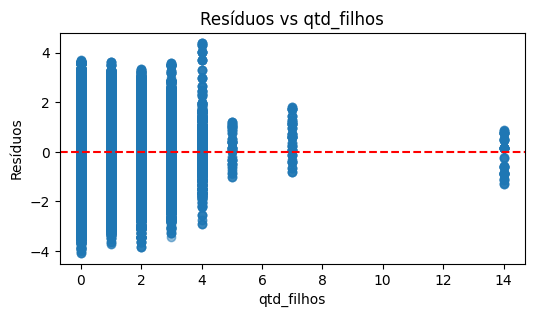

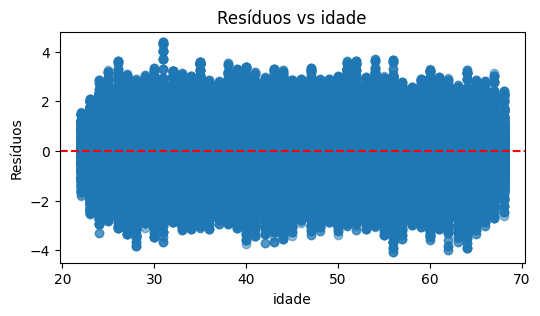

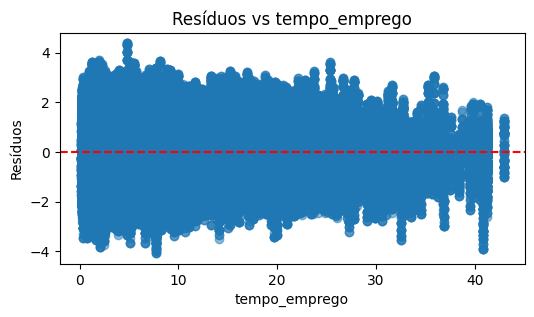

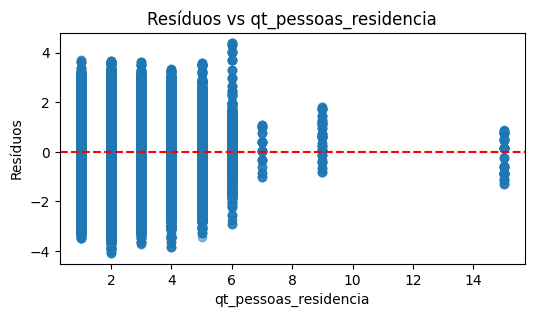

In [6]:
for col in X_train.columns[1:]:  
    plt.figure(figsize=(6,3))
    plt.scatter(X_train[col], residuos, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Resíduos vs {col}")
    plt.xlabel(col)
    plt.ylabel("Resíduos")
    plt.show()

In [5]:
if 'mes_ref' in df_train.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='mes_ref', y=residuos, data=df_train)
    plt.title("Resíduos vs Mês de referência")
    plt.show()

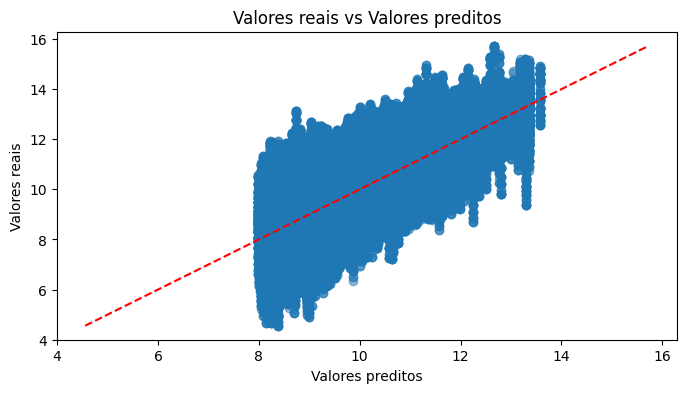

In [6]:
plt.figure(figsize=(8,4))
plt.scatter(y_pred_train, y_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
plt.title("Valores reais vs Valores preditos")
plt.xlabel("Valores preditos")
plt.ylabel("Valores reais")
plt.show()

Resíduos aproximadamente normais, mas podem ter outliers.

Sem padrões claros → independência razoável.

Algum leve padrão ou dispersão crescente → heterocedasticidade leve.

Possíveis desvios podem impactar intervalos de confiança e testes de hipóteses, mas o modelo ainda fornece estimativas de tendência confiáveis.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_total = len(df_treino)
tam_amostra = min(5000, n_total)  # limitar a 5000 observações
idx_amostra = np.random.choice(n_total, size=tam_amostra, replace=False)
df_amostra = df_treino.iloc[idx_amostra]

influence = modelo_original.get_influence()

student_resid = influence.resid_studentized_external[idx_amostra]

cooks_d, _ = influence.cooks_distance
cooks_d = cooks_d[idx_amostra]

outliers_mask = np.abs(student_resid) > 3
num_outliers = int(outliers_mask.sum())
print(f"Número de outliers potenciais (|resid|>3): {num_outliers}")

limite_cook = 4 / tam_amostra
influentes_mask = cooks_d > limite_cook
num_influentes = int(influentes_mask.sum())
print(f"Número de pontos influentes (Cook's D > 4/n_amostra): {num_influentes}")

plt.figure(figsize=(8,4))
plt.hist(student_resid, bins=40, edgecolor='k', alpha=0.7)
plt.title("Distribuição dos Studentized Residuals (amostra)")
plt.xlabel("Resíduo Studentizado")
plt.ylabel("Frequência")
plt.show()

plt.figure(figsize=(8,4))
plt.scatter(range(tam_amostra), cooks_d, alpha=0.6, s=10)
plt.axhline(limite_cook, color='r', linestyle='--', label="Limite 4/n_amostra")
plt.title("Cook's Distance (amostra)")
plt.xlabel("Observações (amostra)")
plt.ylabel("Cook's D")
plt.legend()
plt.show()


In [ ]:
## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

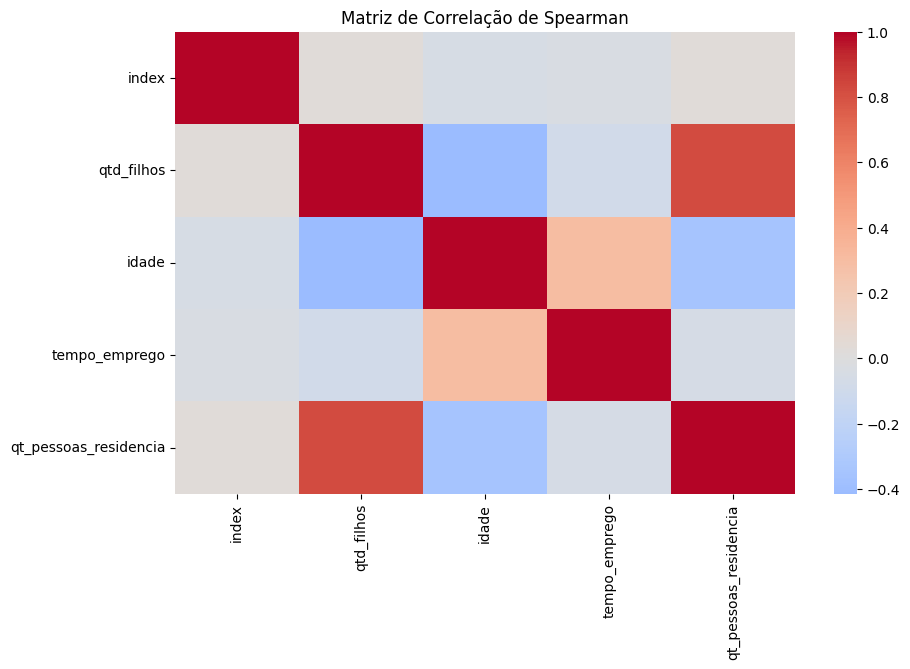


Variance Inflation Factor (VIF):
                variavel        VIF
0                  const  43.395124
2             qtd_filhos   4.944087
5  qt_pessoas_residencia   4.828044
3                  idade   1.234083
4          tempo_emprego   1.068652
1                  index   1.003007


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df.drop(columns=['renda', 'log_renda', 'data_ref'], errors="ignore").select_dtypes(include=[float, int])

plt.figure(figsize=(10,6))
sns.heatmap(X.corr(method="spearman"), cmap="coolwarm", center=0, annot=False)
plt.title("Matriz de Correlação de Spearman")
plt.show()

X_const = add_constant(X)  
vif_data = pd.DataFrame({
    "variavel": X_const.columns,
    "VIF": [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})

print("\nVariance Inflation Factor (VIF):")
print(vif_data.sort_values("VIF", ascending=False))


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [12]:
print(df_treino.columns)

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'log_renda'],
      dtype='object')


                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 5.108e+04
Date:                Sun, 17 Aug 2025   Prob (F-statistic):               0.00
Time:                        19:48:58   Log-Likelihood:            -1.0724e+06
No. Observations:              749997   AIC:                         2.145e+06
Df Residuals:                  749987   BIC:                         2.145e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

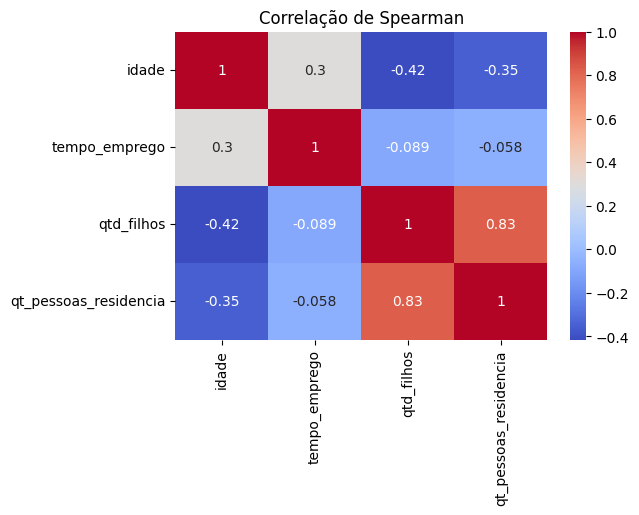

                variavel        VIF
0                  idade   1.232818
1          tempo_emprego   1.068189
2             qtd_filhos   4.944075
3  qt_pessoas_residencia   4.827526
4                  const  39.992101
                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 5.746e+04
Date:                Sun, 17 Aug 2025   Prob (F-statistic):               0.00
Time:                        19:49:06   Log-Likelihood:            -1.0724e+06
No. Observations:              749997   AIC:                         2.145e+06
Df Residuals:                  749988   BIC:                         2.145e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                    

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('previsao_de_renda_II.csv') 

for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].mean())

if 'log_renda' not in df.columns:
    df['log_renda'] = np.log1p(df['renda'])


if 'data_ref' in df.columns:
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    df = df.sort_values('data_ref')

df_treino = df.iloc[:-3]
df_teste  = df.iloc[-3:]

formula_original = "log_renda ~ idade + tempo_emprego + educacao + sexo + qtd_filhos + qt_pessoas_residencia"
modelo_original = sm.OLS.from_formula(formula_original, data=df_treino).fit()
print(modelo_original.summary())

plt.figure(figsize=(6,4))
sns.heatmap(df_treino[['idade','tempo_emprego','qtd_filhos','qt_pessoas_residencia']].corr(method='spearman'),
            annot=True, cmap="coolwarm")
plt.title("Correlação de Spearman")
plt.show()

X = df_treino[['idade','tempo_emprego','qtd_filhos','qt_pessoas_residencia']].assign(const=1)
vif = pd.DataFrame()
vif["variavel"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

formula_ajustado = "log_renda ~ idade + tempo_emprego + educacao + sexo + qtd_filhos"
modelo_ajustado = sm.OLS.from_formula(formula_ajustado, data=df_treino).fit()
print(modelo_ajustado.summary())

y_test = df_teste['log_renda']

y_pred_orig = modelo_original.predict(df_teste)
y_pred_ajust = modelo_ajustado.predict(df_teste)

print("\n=== Modelo Original ===")
print("R² (teste):", r2_score(y_test, y_pred_orig))
print("RMSE (teste):", mean_squared_error(y_test, y_pred_orig, squared=False))

print("\n=== Modelo Ajustado ===")
print("R² (teste):", r2_score(y_test, y_pred_ajust))
print("RMSE (teste):", mean_squared_error(y_test, y_pred_ajust, squared=False))
